# DMPK Repeat Length QC & Visualization
**Author:** Jamil Hanouneh  
**Purpose:** Analyze DMPK consensus repeat sizes from a QC genotype table, classify expansion status, and visualize distributions.


## Overview
This notebook is a structured, notebook-ready version of your original Python script. The **code logic is unchanged**; it is simply organized into steps with explanatory Markdown for clarity and ease of review.

### What you'll do here
- Load a QC genotype CSV (first column used as the index).
- Reshape the data to have samples as rows and metrics as columns.
- Extract **DMPK consensus size** for **allele 0** and **allele 1**.
- Classify repeats using a 50-repeat threshold.
- Visualize the repeat length distribution and list potentially pathogenic expansions.

> **Note:** Column names expected:
> - `DMPK consensus size allele 0`  
> - `DMPK consensus size allele 1`
>
> The CSV's first column should contain metric names; rows correspond to metrics and columns to samples before transposition.


## Requirements
- Python 3
- `pandas`
- `matplotlib`

Install (if needed):
```bash
pip install pandas matplotlib
```


## 1) Configure input path
Update the path below if your CSV is located somewhere else. The current path mirrors your original script.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Path to QC genotype table (from your original script)
qc_file = r'C:\Users\jamel\Desktop\ALS\data\QC-Target_Genotype_Table.csv'

## 2) Load CSV and inspect
Loads the CSV with the **first column as the index**, then displays a preview for sanity-checking.


In [3]:
# Step 1: Load the CSV, setting the first column as the index
qc_df = pd.read_csv(qc_file, index_col=0)

# Debug: Print the first few rows to verify structure
print("Raw CSV head:")
print(qc_df.head())

Raw CSV head:
                             NA03697B2 NA037562 NA04026C1 NA05131A2 NA06153B4  \
Sample                                                                          
ATN1 repeat unit                   CAG      CAG       CAG       CAG       CAG   
ATN1 read count allele 0           NaN      NaN       NaN       NaN       NaN   
ATN1 consensus size allele 0       NaN      NaN       NaN       NaN       NaN   
ATN1 min size allele 0             NaN      NaN       NaN       NaN       NaN   
ATN1 max size allele 0             NaN      NaN       NaN       NaN       NaN   

                             NA06905A9 NA06926A4 NA09237E2 NA13509A2 NA135152  \
Sample                                                                          
ATN1 repeat unit                   CAG       CAG       CAG       CAG      CAG   
ATN1 read count allele 0           NaN       NaN       NaN       NaN      NaN   
ATN1 consensus size allele 0       NaN       NaN       NaN       NaN      NaN   
ATN1 min size

## 3) Transpose and normalize column names
Transpose so that **samples become rows** and **metrics become columns**, and carry over the sample IDs to a `Sample` column.


In [4]:
# Step 2: Transpose to make samples rows and metrics columns
qc_df = qc_df.T.reset_index()
qc_df = qc_df.rename(columns={'index': 'Sample'})

# Debug: Print transposed DataFrame
print("\nTransposed DataFrame head:")
print(qc_df.head())


Transposed DataFrame head:
Sample     Sample ATN1 repeat unit ATN1 read count allele 0  \
0       NA03697B2              CAG                      NaN   
1        NA037562              CAG                      NaN   
2       NA04026C1              CAG                      NaN   
3       NA05131A2              CAG                      NaN   
4       NA06153B4              CAG                      NaN   

Sample ATN1 consensus size allele 0 ATN1 min size allele 0  \
0                               NaN                    NaN   
1                               NaN                    NaN   
2                               NaN                    NaN   
3                               NaN                    NaN   
4                               NaN                    NaN   

Sample ATN1 max size allele 0 ATN1 motif counts allele 0  \
0                         NaN                        NaN   
1                         NaN                        NaN   
2                         NaN           

## 4) Extract DMPK consensus sizes (allele 0 & allele 1)
Build a tidy table with `Sample`, `Allele`, and `Consensus Size` from the expected columns.


In [5]:
# Step 3: Extract DMPK consensus sizes for allele 0 and allele 1
dmpk_data = []
for sample in qc_df['Sample']:
    # Get row for this sample
    sample_row = qc_df[qc_df['Sample'] == sample]
    
    # Extract DMPK consensus size for allele 0
    if 'DMPK consensus size allele 0' in qc_df.columns:
        value = sample_row['DMPK consensus size allele 0'].iloc[0]
        if pd.notna(value):
            dmpk_data.append({'Sample': sample, 'Allele': 'Allele 0', 'Consensus Size': int(value)})
    
    # Extract DMPK consensus size for allele 1
    if 'DMPK consensus size allele 1' in qc_df.columns:
        value = sample_row['DMPK consensus size allele 1'].iloc[0]
        if pd.notna(value):
            dmpk_data.append({'Sample': sample, 'Allele': 'Allele 1', 'Consensus Size': int(value)})

# Create DataFrame
dmpk_df = pd.DataFrame(dmpk_data)

# Debug: Print DMPK DataFrame
print("\nDMPK DataFrame:")
print(dmpk_df)


DMPK DataFrame:
      Sample    Allele  Consensus Size
0  NA03697B2  Allele 0              36
1  NA03697B2  Allele 1            1158
2   NA037562  Allele 0              39
3   NA037562  Allele 1             957
4   NA232652  Allele 0              36
5   NA232652  Allele 1             237
6   NA233782  Allele 0              66
7   NA233782  Allele 1             399


## 5) QC: Verify extraction & classify expansions
- If no rows were extracted, the notebook stops with a message.
- Classify repeats: values **> 50** are labeled **"Expanded (Potential Myotonic Dystrophy Risk)"**; others as **"Normal"**.


In [6]:
# Check if DataFrame is empty
if dmpk_df.empty:
    print("Error: No DMPK data extracted. Check CSV content for 'DMPK consensus size' rows.")
    import sys; sys.exit(0)

# Step 4: Classify repeats (>50 repeats considered potentially pathogenic for DMPK)
dmpk_df['Status'] = dmpk_df['Consensus Size'].apply(
    lambda x: 'Expanded (Potential Myotonic Dystrophy Risk)' if x > 50 else 'Normal'
)

# Print summary
print("\nDMPK Repeat Lengths Across Samples:")
print(dmpk_df[['Sample', 'Allele', 'Consensus Size', 'Status']].sort_values('Consensus Size', ascending=False))


DMPK Repeat Lengths Across Samples:
      Sample    Allele  Consensus Size  \
1  NA03697B2  Allele 1            1158   
3   NA037562  Allele 1             957   
7   NA233782  Allele 1             399   
5   NA232652  Allele 1             237   
6   NA233782  Allele 0              66   
2   NA037562  Allele 0              39   
0  NA03697B2  Allele 0              36   
4   NA232652  Allele 0              36   

                                         Status  
1  Expanded (Potential Myotonic Dystrophy Risk)  
3  Expanded (Potential Myotonic Dystrophy Risk)  
7  Expanded (Potential Myotonic Dystrophy Risk)  
5  Expanded (Potential Myotonic Dystrophy Risk)  
6  Expanded (Potential Myotonic Dystrophy Risk)  
2                                        Normal  
0                                        Normal  
4                                        Normal  


## 6) Visualize repeat length distribution
Generates a bar chart of DMPK repeat lengths by `Sample_Allele`, with a dashed line at the **50-repeat** threshold.


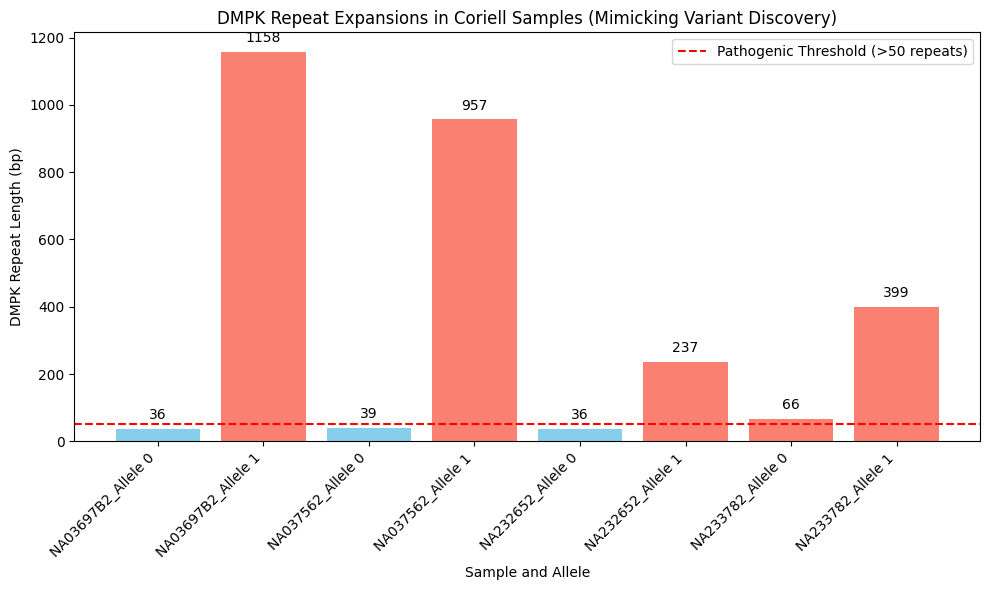

In [7]:
# Step 5: Create a bar chart for repeat length distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(dmpk_df['Sample'] + '_' + dmpk_df['Allele'], dmpk_df['Consensus Size'], 
               color=dmpk_df['Status'].map({'Normal': 'skyblue', 'Expanded (Potential Myotonic Dystrophy Risk)': 'salmon'}))
plt.axhline(y=50, color='red', linestyle='--', label='Pathogenic Threshold (>50 repeats)')
plt.xlabel('Sample and Allele')
plt.ylabel('DMPK Repeat Length (bp)')
plt.title('DMPK Repeat Expansions in Coriell Samples (Mimicking Variant Discovery)')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add labels to bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, int(yval), ha='center', va='bottom')

# Step 6: Generate the chart (Chart.js structure retained from your script; not used directly here)
chartjs = {
    "type": "bar",
    "data": {
        "labels": (dmpk_df['Sample'] + '_' + dmpk_df['Allele']).tolist(),
        "datasets": [{
            "label": "DMPK Repeat Length (bp)",
            "data": dmpk_df['Consensus Size'].tolist(),
            "backgroundColor": dmpk_df['Status'].map({
                'Normal': 'rgba(135, 206, 235, 0.7)',  # skyblue
                'Expanded (Potential Myotonic Dystrophy Risk)': 'rgba(250, 128, 114, 0.7)'  # salmon
            }).tolist(),
            "borderColor": dmpk_df['Status'].map({
                'Normal': 'rgba(135, 206, 235, 1)',
                'Expanded (Potential Myotonic Dystrophy Risk)': 'rgba(250, 128, 114, 1)'
            }).tolist(),
            "borderWidth": 1
        }]
    },
    "options": {
        "scales": {
            "y": {
                "beginAtZero": True,
                "title": {
                    "display": True,
                    "text": "DMPK Repeat Length (bp)"
                }
            },
            "x": {
                "title": {
                    "display": True,
                    "text": "Sample and Allele"
                }
            }
        },
        "plugins": {
            "legend": {
                "display": False
            },
            "title": {
                "display": True,
                "text": "DMPK Repeat Expansions in Coriell Samples"
            },
            "annotation": {
                "annotations": {
                    "line1": {
                        "type": "line",
                        "yMin": 50,
                        "yMax": 50,
                        "borderColor": "red",
                        "borderWidth": 2,
                        "borderDash": [5, 5],
                        "label": {
                            "content": "Pathogenic Threshold (>50 repeats)",
                            "enabled": True,
                            "position": "end"
                        }
                    }
                }
            }
        }
    }
}

plt.show()

## 7) List samples with potentially pathogenic expansions
Outputs a compact table of samples/alleles with **Consensus Size > 50**.


In [8]:
# Step 7: Summarize potentially pathogenic expansions
pathogenic = dmpk_df[dmpk_df['Status'] == 'Expanded (Potential Myotonic Dystrophy Risk)']
print("\nSamples with Potentially Pathogenic DMPK Expansions (>50 repeats):")
print(pathogenic[['Sample', 'Allele', 'Consensus Size']])


Samples with Potentially Pathogenic DMPK Expansions (>50 repeats):
      Sample    Allele  Consensus Size
1  NA03697B2  Allele 1            1158
3   NA037562  Allele 1             957
5   NA232652  Allele 1             237
6   NA233782  Allele 0              66
7   NA233782  Allele 1             399


---
## Interpretation & Notes
- The **50-repeat** threshold is a commonly referenced cutoff for potential pathogenic expansion in DMPK (myotonic dystrophy type 1 context). Adapt thresholds as needed for your pipeline/reporting conventions.
- If the extraction step yields no rows, double-check that your CSV has the expected columns and that the **first column is the metric/index**.

## Troubleshooting
- **Empty output**: Ensure the CSV path is correct and that the file is accessible.
- **Missing columns**: Confirm the exact column names match `DMPK consensus size allele 0` and `DMPK consensus size allele 1`.
- **Plot overlap**: If many samples are present, consider increasing figure size or filtering/aggregating before plotting.
